In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

## Download Data

### Read Image Data

In [2]:
file_path = 'dataset/sequences/00/image_0/' # path to the left camera image (sequence of frames)
left_images = os.listdir(file_path) # list of all images in the directory
type(left_images) # check the type of the list

list

In [3]:
left_images[:5] # check the first 5 images in the list

['000000.png', '000001.png', '000002.png', '000003.png', '000004.png']

In [4]:
len(left_images) # check the number of images in the list

4541

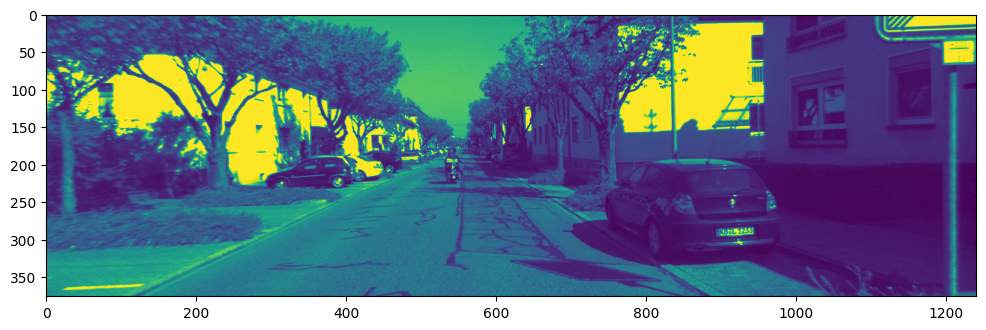

In [5]:
plt.figure(figsize=(12, 4)) # set the figure size for displaying images
plt.imshow(cv2.imread(file_path + left_images[0], 0)) # read and display the first image in grayscale

In [6]:
first_image = cv2.imread(file_path + left_images[0], 0) # read the first image in grayscale
first_image.shape # check the shape of the first image
# The shape of the image is (height, width) in pixels

(376, 1241)

### Read Point Cloud Data (Binaly File)

In [7]:
# file_path = 'dataset/sequences/00/' 
# velodyne_file = os.listdir(file_path + 'velodyne') # list of all velodyne files in the directory
# pointcloud = np.fromfile(file_path + 'velodyne/' + velodyne_file[0], dtype=np.float32) # read the first velodyne file

In [8]:
# pointcloud = pointcloud.reshape(-1, 4) # reshape the point cloud data to have 4 columns (x, y, z, intensity)
# pointcloud.shape # check the shape of the point cloud data

In [9]:
# pointcloud.dtype # check the data type of the point cloud data
# # The point cloud data is of type float32, which means each value is a 32-bit floating point number

In [10]:
# %matplotlib notebook # enable see 3D diagram in notebook

In [11]:
# fig = plt.figure(figsize=(8, 8)) # set the figure size for 3D plot
# ax = fig.add_subplot(111, projection='3d') # create a 3D subplot

# xs = pointcloud[:, 0] # x-coordinates of the point cloud
# ys = pointcloud[:, 1] # y-coordinates of the point cloud
# zs = pointcloud[:, 2] # z-coordinates of the point cloud

# ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs))) # get axes in same scale
# ax.scatter(xs, ys, zs, s=0.01) # scatter plot the point cloud data)
# ax.grid(False) # disable the grid
# ax.axis('off') # turn off the axis
# ax.set_xlabel('x') # set x-axis label
# ax.set_ylabel('y') # set y-axis label
# ax.set_zlabel('z') # set z-axis label

# ax.view_init(elev=40, azim=100) # set the initial view angle of the 3D plot

### Dataset Handling

In [12]:
calib = pd.read_csv('dataset/sequences/00/calib.txt', delimiter=' ', header=None, index_col=0) # read the calibration file
calib # check the contents of the calibration file
# The calibration file contains intrinsic and extrinsic parameters for the camera and lidar sensors

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
P0:,718.856,0.0,607.1928,0.00000,0.0,718.856,185.2157,0.000000,0.0,0.0,1.0,0.000000
P1:,718.856,0.0,607.1928,-386.14480,0.0,718.856,185.2157,0.000000,0.0,0.0,1.0,0.000000
P2:,718.856,0.0,607.1928,45.38225,0.0,718.856,185.2157,-0.113089,0.0,0.0,1.0,0.003780
P3:,718.856,0.0,607.1928,-337.28770,0.0,718.856,185.2157,2.369057,0.0,0.0,1.0,0.004915


P0 to P3 are rectified projected matrices for each camera. We need only P0 and P1 because we have black and white cameras

In [13]:
class Dataset_Handler():
    def __init__(self, sequence, lidar=False, progress_bar=True, low_memory=True):

        """
        Dataset_Handler class to handle the KITTI dataset for odometry tasks.
        This class is designed to load images and point clouds from the KITTI dataset,
        as well as the corresponding ground truth poses.
        It also provides methods to reset the frames and access the data in a memory-efficient way.
        
        Parameters:
        sequence (str): The sequence number of the KITTI dataset to load.
        lidar (bool): If True, loads the lidar data. Default is False.
        progress_bar (bool): If True, shows a progress bar while loading the data. Default is True.
        low_memory (bool): If True, loads the data in a memory-efficient way. Default is True.
        """

        import pandas as pd
        import os
        import cv2
        
        # This will tell our odometry function if handler contains lidar info
        self.lidar = lidar
        # This will tell odometry functin how to access data from this object
        self.low_memory = low_memory
        
        # Set file paths and get ground truth poses
        self.seq_dir = 'dataset/sequences/{}/'.format(sequence)
        self.poses_dir = 'dataset/poses/{}.txt'.format(sequence)
        poses = pd.read_csv(self.poses_dir, delimiter=' ', header=None)

        # Get sorted names of files to iterate through
        self.left_image_files = os.listdir(self.seq_dir + 'image_0')
        self.right_image_files = os.listdir(self.seq_dir + 'image_1')
        if self.lidar:
            self.velodyne_files = os.listdir(self.seq_dir + 'velodyne')   
        self.num_frames = len(self.left_image_files)
        self.lidar_path = self.seq_dir + 'velodyne/'     
        
        # Get calibration details for scene
        # P0 and P1 are Grayscale cams, P2 and P3 are RGB cams
        calib = pd.read_csv(self.seq_dir + 'calib.txt', delimiter=' ', header=None, index_col=0) # Read the calibration file
        self.P0 = np.array(calib.loc['P0:']).reshape((3,4))
        self.P1 = np.array(calib.loc['P1:']).reshape((3,4))
        self.P2 = np.array(calib.loc['P2:']).reshape((3,4))
        self.P3 = np.array(calib.loc['P3:']).reshape((3,4))
        if self.lidar:
            # This is the transformation matrix for LIDAR
            self.Tr = np.array(calib.loc['Tr:']).reshape((3,4))
        
        # Get times and ground truth poses
        self.times = np.array(pd.read_csv(self.seq_dir + 'times.txt', 
                                          delimiter=' ', 
                                          header=None))
        self.gt = np.zeros((len(poses), 3, 4))
        for i in range(len(poses)):
            self.gt[i] = np.array(poses.iloc[i]).reshape((3, 4))

        
        # Get images and lidar loaded
        if self.low_memory:
            # If using low_memory, we will not load all images into memory
            # This is to save RAM, as the dataset is large and can take up to 32GB of RAM
            # Will use generators to provide data sequentially to save RAM
            # Use class method to set up generators
            self.reset_frames()
            # Store original frame to memory for testing functions
            self.first_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                               + self.left_image_files[0], 0)
            self.first_image_right = cv2.imread(self.seq_dir + 'image_1/' 
                                               + self.right_image_files[0], 0)
            self.second_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                               + self.left_image_files[1], 0)
            if self.lidar:
                self.first_pointcloud = np.fromfile(self.lidar_path + self.velodyne_files[0],
                                                    dtype=np.float32, 
                                                    count=-1).reshape((-1, 4))

            # Get image height and width from first image
            # This is the first image in the sequence, used for testing functions
            self.imheight = self.first_image_left.shape[0] # Get image height
            self.imwidth = self.first_image_left.shape[1] # Get image width
            
        else:
            # If RAM is not a concern (>32GB), pass low_memory=False
            if progress_bar:
                import progressbar
                bar = progressbar.ProgressBar(max_value=self.num_frames)
            self.images_left = []
            self.images_right = []
            self.pointclouds = []
            for i, name_left in enumerate(self.left_image_files):
                name_right = self.right_image_files[i]
                self.images_left.append(cv2.imread(self.seq_dir + 'image_0/' + name_left))
                self.images_right.append(cv2.imread(self.seq_dir + 'image_1/' + name_right))
                if self.lidar:
                    pointcloud = np.fromfile(self.lidar_path + self.velodyne_files[i], 
                                             dtype=np.float32, 
                                             count=-1).reshape((-1,4))
                    self.pointclouds.append(pointcloud)
                if progress_bar:
                    bar.update(i+1)
                
            self.imheight = self.images_left[0].shape[0]
            self.imwidth = self.images_left[0].shape[1]
            # Keep consistent instance variable names as when using low_memory
            self.first_image_left = self.images_left[0]
            self.first_image_right = self.images_right[0]
            self.second_image_left = self.images_left[1]
            if self.lidar:
                self.first_pointcloud = self.pointclouds[0]
            
    def reset_frames(self):
        # Resets all generators to the first frame of the sequence
        self.images_left = (cv2.imread(self.seq_dir + 'image_0/' + name_left, 0)
                            for name_left in self.left_image_files)
        self.images_right = (cv2.imread(self.seq_dir + 'image_1/' + name_right, 0)
                            for name_right in self.right_image_files)
        if self.lidar:
            self.pointclouds = (np.fromfile(self.lidar_path + velodyne_file, 
                                            dtype=np.float32, 
                                            count=-1).reshape((-1, 4)) # 4 rows and what ever number of columns
                                for velodyne_file in self.velodyne_files)
        pass

In [14]:
# Creating a handler object for low_memory (<32GB) setups:
handler = Dataset_Handler('00')

In [15]:
# Creating a handler object for high_memory (>32GB) setups:
handler2 = Dataset_Handler('00', low_memory=False) 

  0% (0 of 4541) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (9 of 4541) |                       | Elapsed Time: 0:00:00 ETA:   0:00:55
  0% (17 of 4541) |                      | Elapsed Time: 0:00:00 ETA:   0:00:58
  0% (25 of 4541) |                      | Elapsed Time: 0:00:00 ETA:   0:00:59
  0% (33 of 4541) |                      | Elapsed Time: 0:00:00 ETA:   0:00:59
  0% (41 of 4541) |                      | Elapsed Time: 0:00:00 ETA:   0:01:00
  1% (49 of 4541) |                      | Elapsed Time: 0:00:00 ETA:   0:01:00
  1% (57 of 4541) |                      | Elapsed Time: 0:00:00 ETA:   0:01:00
  1% (65 of 4541) |                      | Elapsed Time: 0:00:00 ETA:   0:01:00
  1% (73 of 4541) |                      | Elapsed Time: 0:00:00 ETA:   0:01:00
  1% (81 of 4541) |                      | Elapsed Time: 0:00:01 ETA:   0:00:59
  1% (89 of 4541) |                      | Elapsed Time: 0:00:01 ETA:   0:00:59
  2% (97 of 4541) |                     

In [16]:
# enable inline plotting for Jupyter Notebook
%matplotlib inline 

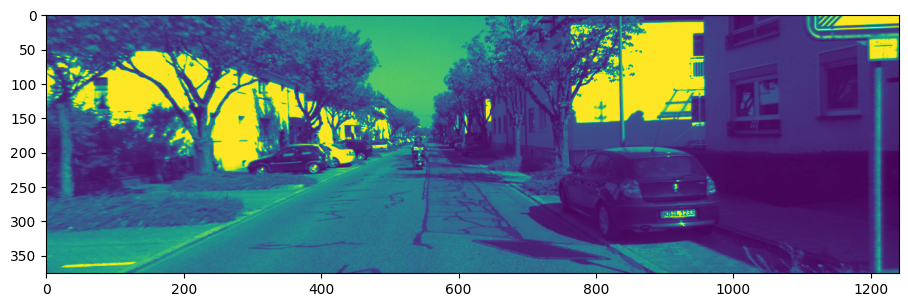

In [17]:
# Display the first image in the sequence using the low_memory handler
plt.figure(figsize=(11, 7)) # set the figure size for displaying images
plt.imshow(next(handler.images_left))

In [18]:
handler.first_image_left.shape # check the shape of the first image in the low_memory handler
# Display the first image in the sequence using the high_memory handler

(376, 1241)

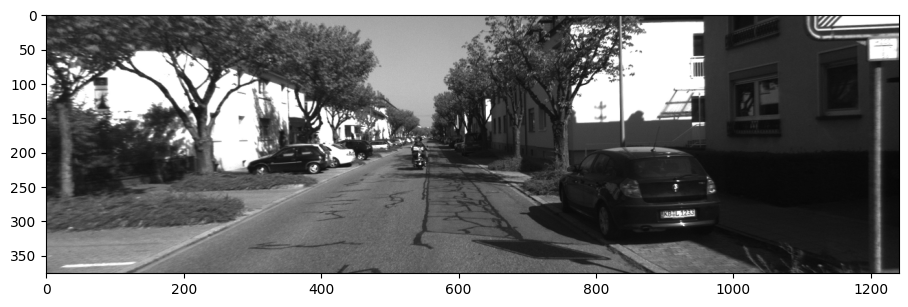

In [19]:
# Display the first image in the sequence using the high_memory handler
plt.figure(figsize=(11, 7)) # set the figure size for displaying images
plt.imshow(handler2.images_left[0])

## Create Stereo Depth

In [20]:
def compute_left_disparity_map(img_left, img_right, matcher='bm', rgb=False, verbose=False):
    '''
    Takes a left and right stereo pair of images and computes the disparity map for the left
    image. Pass rgb=True if the images are RGB.
    
    Arguments:
    img_left -- image from left camera
    img_right -- image from right camera
    
    Optional Arguments:
    matcher -- (str) can be 'bm' for StereoBM or 'sgbm' for StereoSGBM matching
    rgb -- (bool) set to True if passing RGB images as input
    verbose -- (bool) set to True to report matching type and time to compute
    
    Returns:
    disp_left -- disparity map for the left camera image
    
    '''
    # Feel free to read OpenCV documentation and tweak these values. These work well
    sad_window = 6
    num_disparities = sad_window*16
    block_size = 11
    matcher_name = matcher
    
    if matcher_name == 'bm': # StereoBM is a block matching algorithm
        # The block size must be odd and greater than 0
        matcher = cv2.StereoBM_create(numDisparities=num_disparities, # number of disparities
                                      blockSize=block_size # size of the block to match
                                     )
        
    elif matcher_name == 'sgbm': # StereoSGBM is a semi-global block matching algorithm
        # The block size must be odd and greater than 0
        matcher = cv2.StereoSGBM_create(numDisparities=num_disparities, # number of disparities
                                        minDisparity=0, # minimum disparity
                                        blockSize=block_size, # size of the block to match
                                        P1 = 8 * 3 * sad_window ** 2, # penalty for disparity change by 1 pixel
                                        P2 = 32 * 3 * sad_window ** 2, # penalty for disparity change by 1 pixel
                                        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY # mode for SGBM
                                       )
    if rgb: # If the images are RGB, convert them to grayscale
        # Convert the images to grayscale for disparity computation
        img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
        img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

    start = datetime.datetime.now() # Start the timer to compute the disparity map
    disp_left = matcher.compute(img_left, img_right).astype(np.float32)/16 # Compute the disparity map using the matcher
    end = datetime.datetime.now()  # End the timer to compute the disparity map

    if verbose: # If verbose is True, print the time taken to compute the disparity map
        print(f'Time to compute disparity map using Stereo{matcher_name.upper()}:', end-start)
    
    return disp_left

Time to compute disparity map using StereoBM: 0:00:00.104714


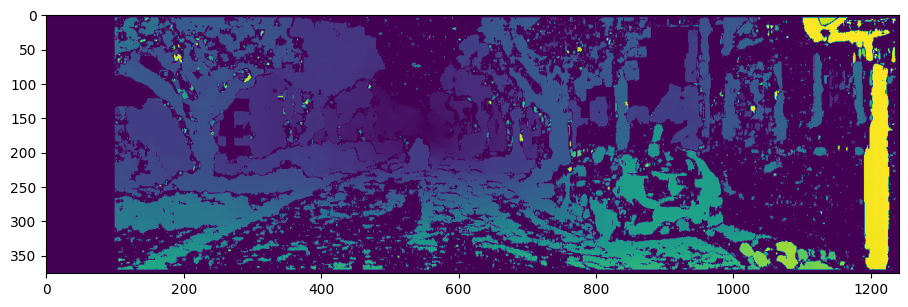

In [21]:
# Compute disparity using StereoBM
disp = compute_left_disparity_map(handler.first_image_left, 
                                  handler.first_image_right, 
                                  matcher='bm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp);

**StereoBM:** Faster compute, recommend for real-time visual odom but it missing some datato compute depth. Can fix by filter to make sure that only use feature that fall in area where to do have good disparity estimation.

Time to compute disparity map using StereoSGBM: 0:00:00.063260


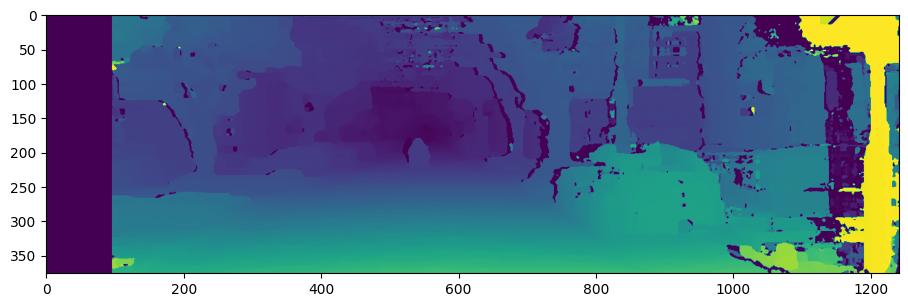

In [22]:
# Now to compare this to StereoSGBM
disp = compute_left_disparity_map(handler.first_image_left, 
                                  handler.first_image_right, 
                                  matcher='sgbm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp);

**StereoSGBM:** No missing data but take time to compute longer.

At left of image. It have **rectangle purple** where the right camera not have any information because there no overlap or baseline between two images or camera.

It going to be **a part that not useful** entire sequence of images of all frames. It can not compute disparity information so it can not compute depth information.

So we will **mask or remove it out** when start detect feature.

In [23]:
disp[0, 0] # check the value of the disparity map at (0, 0) where the rectangle purple is.
# The value of the disparity map at (0, 0) is the disparity value for that pixel in the left image

-1.0

**-1.0** is the value in the **rectangle purple** at left image.

In [24]:
# Look other disparity values in the image
disp[disp > -1.0].min() # check the minimum value of the disparity map that is greater than -1

0.0

In [25]:
# Check the minimum value of the disparity map that is greater than 0
disp[disp > 0].min()

0.5625

**0.5625** is the value of the **furthest point**.

In [26]:
disp[disp > 0].max() # check the maximum value of the disparity map that is greater than 0

95.0

**95.0** is the value of the **nearest point**.

It is **distance** in **pixel** horizontally between those point.

In [27]:
handler.P0 # check the intrinsic parameters of the left camera
# The intrinsic parameters of the left camera are stored in the P0 matrix

array([[718.856 ,   0.    , 607.1928,   0.    ],
       [  0.    , 718.856 , 185.2157,   0.    ],
       [  0.    ,   0.    ,   1.    ,   0.    ]])

This is projection matrix for the left camera.

### **Decompose**

#### Example how to decomposes the P0 matrix into intrinsic and extrinsic parameters


In [28]:
# Example how to decomposes the P0 matrix into intrinsic and extrinsic parameters
k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(handler.P0) # decompose the projection matrix into intrinsic and extrinsic parameters
'''
'k' is the intrinsic matrix, it is where the top left of image plane compared to the camera center. it call u, v (pixel) in the image plane
'r' is the rotation matrix, 
't' is the translation vector, and the last 4 parameters are not used
# The intrinsic parameters are stored in the k matrix, the rotation matrix is stored in the r matrix,
'''
print(k) # print the intrinsic parameters
print(r) # print the rotation matrix
print(t) # print the translation vector
# The intrinsic parameters are stored in the k matrix, the rotation matrix is stored in the r matrix,

[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[0.]
 [0.]
 [0.]
 [1.]]


![Intrinsic Matrix](KITTI_visual_odometry/images/intrinsic_matrix.png)

718.856 (x,y direction) is **focal lenght** of camera in pixels, and it have two same number because it is rectangular pixels.

and there is no rotaion or translation because this **point k value is origin of camera**.

#### Example how to decomposes the P1 matrix into intrinsic and extrinsic parameters

In [29]:
# Example how to decomposes the P1 matrix into intrinsic and extrinsic parameters
k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(handler.P1) # decompose the projection matrix into intrinsic and extrinsic parameters
'''
'k' is the intrinsic matrix, it is where the top left of image plane compared to the camera center. it call u, v (pixel) in the image plane
'r' is the rotation matrix, 
't' is the translation vector, and the last 4 parameters are not used
# The intrinsic parameters are stored in the k matrix, the rotation matrix is stored in the r matrix,
'''
print(k) # print the intrinsic parameters
print(r) # print the rotation matrix
print(t.round(4)) # print the translation vector
# The intrinsic parameters are stored in the k matrix, the rotation matrix is stored in the r matrix,

[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 0.4732]
 [ 0.    ]
 [-0.    ]
 [ 0.8809]]


Look at the translation vector. If thing it in terms of the matric 3D universe in **meters**, We need to **convert 0.8809 to 1** by divide t with 0.8809

In [30]:
# t[3] is 0.8809
print((t/t[3]).round(4))

[[ 0.5372]
 [ 0.    ]
 [-0.    ]
 [ 1.    ]]


The answer we got is 0.54 meters translation to the right of the left camera.

#### **Decompose Function**

In [31]:
def decompose_projection_matrix(p):
    '''
    Shortcut to use cv2.decomposeProjectionMatrix(), which only returns k, r, t, and divides
    t by the scale, then returns it as a vector with shape (3,) (non-homogeneous)
    
    Arguments:
    p -- projection matrix to be decomposed
    
    Returns:
    k, r, t -- intrinsic matrix, rotation matrix, and 3D translation vector
    
    '''
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = (t / t[3])[:3] # divide t by the scale and take only the first 3 elements
    
    return k, r, t

In [32]:
k_left, r_left, t_left = decompose_projection_matrix(handler.P0)
k_right, r_right, t_right = decompose_projection_matrix(handler.P1)

#### **Calculate Depth Map Function**

In [33]:
def calc_depth_map(disp_left, k_left, t_left, t_right, rectified=True):
    '''
    Calculate depth map using a disparity map, intrinsic camera matrix, and translation vectors
    from camera extrinsic matrices (to calculate baseline). Note that default behavior is for
    rectified projection matrix for right camera. If using a regular projection matrix, pass
    rectified=False to avoid issues.
    
    Arguments:
    disp_left -- disparity map of left camera
    k_left -- intrinsic matrix for left camera
    t_left -- translation vector for left camera
    t_right -- translation vector for right camera
    
    Optional Arguments:
    rectified -- (bool) set to False if t_right is not from rectified projection matrix
    Note:   if compute baseline with a extrinsic matrix for the right camera, that was a normal non-rectified extrinsic matrix
            then set rectified=False. This will compute the baseline as t_left - t_right.
    
    Returns:
    depth_map -- calculated depth map for left camera
    
    '''
    # Get focal length of x axis for left camera
    f = k_left[0][0]
    
    # Calculate baseline of stereo pair
    if rectified:
        b = t_right[0] - t_left[0] 
    else:
        b = t_left[0] - t_right[0]
        
    # Avoid instability and division by zero
    disp_left[disp_left == -1.0] = 0.1
    disp_left[disp_left == 0.0] = 0.1
    
    # Make empty depth map then fill with depth
    depth_map = np.ones(disp_left.shape)
    depth_map = f * b / disp_left
    
    return depth_map # Solve for Z

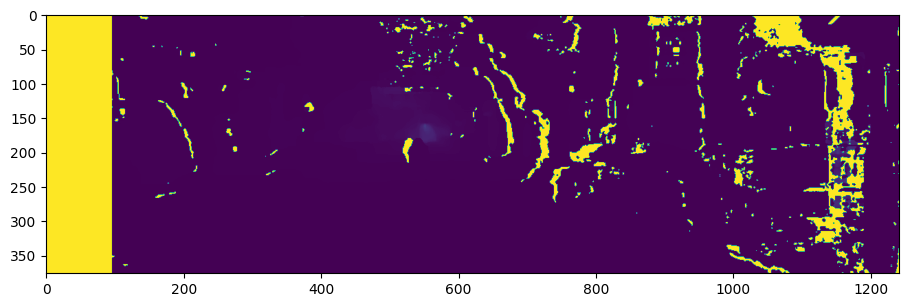

In [34]:
depth = calc_depth_map(disp, k_left, t_left, t_right)
plt.figure(figsize=(11,7))
plt.grid(False) # disable the grid
plt.imshow(depth);

In [35]:
# Let's see what the depth is in the yellow band to the left
depth[0,0]

3861.4479424599417

In [36]:
# Let's see if this is the same as the maximum estimated depth
depth.max()

3861.4479424599417

In [37]:
from jupyterthemes import jtplot # import the jupyterthemes package to set the theme for the notebook
jtplot.style(theme='onedork') # set the theme to onedork

(array([405883.,    646.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  60087.]),
 array([   4.06468211,  389.80300814,  775.54133418, 1161.27966021,
        1547.01798625, 1932.75631228, 2318.49463832, 2704.23296435,
        3089.97129039, 3475.70961642, 3861.44794246]),
 <BarContainer object of 10 artists>)

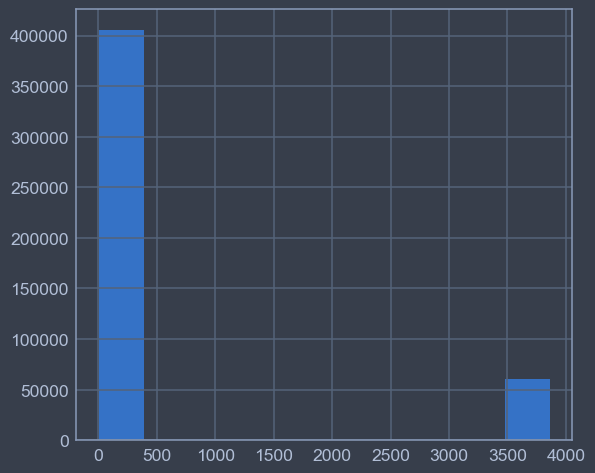

In [38]:
plt.hist(depth.flatten()) # plot a histogram of the depth values

From Hist Graph, Between 500 to 3000 meters is just nothing in here.

Value at left side is created by adding 0.1. We don't know what disparity is here.

In [39]:
depth[depth < depth.max()].flatten().max() # check the maximum depth value that is less than the maximum depth value in the depth map
# Check the minimum depth value that is less than the maximum depth value in the depth map

686.4796444444444

So the maximum depth measurement that we have it isn't 3861.4479 meters, It's only 686.4796 meters

In [40]:
''' 
We want to find the width of the yellow band, in order to 
create a mask to prevent the feature detector from searching in a useless area for features
on every frame, which would waste time. 
 '''
for i, pixel in enumerate(depth[4]):
    if pixel < depth.max():
        print('First non-max value at index', i)
        break

First non-max value at index 96


Now we know anything between 0 to 96 colum is useless in our depth map or in our image.

So we will going to make a empty array (mask) 

In [41]:
depth.shape # check the shape of the depth map

(376, 1241)

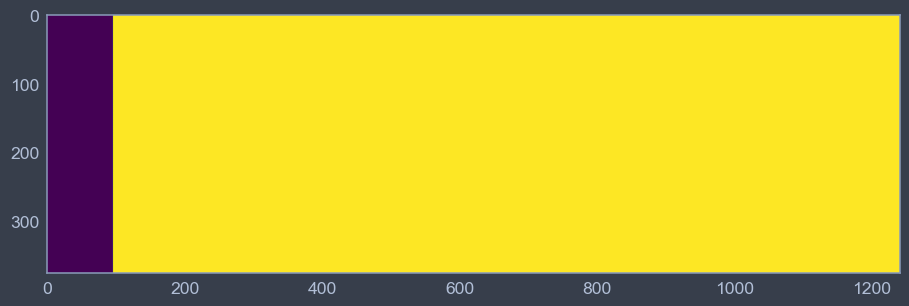

In [42]:
# We can constuct a mask using this information like so
mask = np.zeros(depth.shape, dtype=np.uint8)
ymax = depth.shape[0] # get the maximum height of the depth map
xmax = depth.shape[1] # get the maximum width of the depth map
cv2.rectangle(mask, (96,0), (xmax,ymax), (255), thickness = -1)
plt.figure(figsize=(11,7))
plt.grid(False) # disable the grid
plt.imshow(mask);

#### **Wrapper Function**

In [43]:
# Let's make an all-inclusive function to get the depth from an incoming set of stereo images
def stereo_2_depth(img_left, img_right, P0, P1, matcher='bm', rgb=False, verbose=False, rectified=True):
    '''
    Takes stereo pair of images and returns a depth map for the left camera. If your projection
    matrices are not rectified, set rectified=False.
    
    Arguments:
    img_left -- image of left camera
    img_right -- image of right camera
    P0 -- Projection matrix for the left camera
    P1 -- Projection matrix for the right camera
    
    Optional Arguments:
    matcher -- (str) can be 'bm' for StereoBM or 'sgbm' for StereoSGBM
    rgb -- (bool) set to True if images passed are RGB. Default is False
    verbose -- (bool) set to True to report computation time and method
    rectified -- (bool) set to False if P1 not rectified to P0. Default is True
    
    Returns:
    depth -- depth map for left camera
    
    '''
    # Compute disparity map
    disp = compute_left_disparity_map(img_left, 
                                      img_right, 
                                      matcher=matcher, 
                                      rgb=rgb, 
                                      verbose=verbose)
    # Decompose projection matrices
    k_left, r_left, t_left = decompose_projection_matrix(P0)
    k_right, r_right, t_right = decompose_projection_matrix(P1)
    # Calculate depth map for left camera
    depth = calc_depth_map(disp, k_left, t_left, t_right)
    
    return depth

Time to compute disparity map using StereoSGBM: 0:00:00.061097


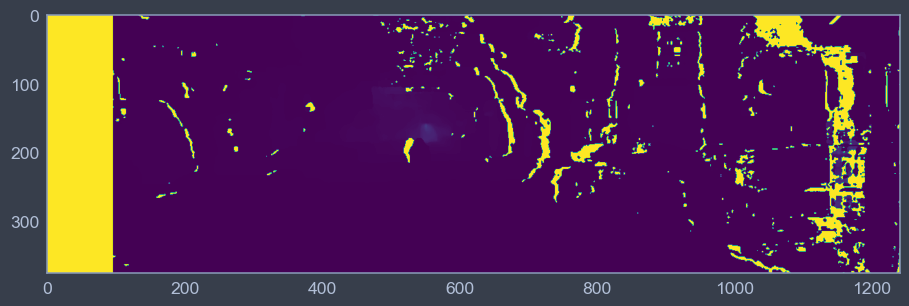

In [44]:
depth = stereo_2_depth(handler.first_image_left, 
                       handler.first_image_right, 
                       handler.P0, 
                       handler.P1, 
                       matcher='sgbm', 
                       rgb=False, 
                       verbose=True, 
                       rectified=True)
plt.figure(figsize=(11,7))
plt.grid(False) # disable the grid
plt.imshow(depth); # display the depth map

## **Depth Visualization**

In [45]:
for i, d in enumerate(depth[200:, :].flatten()):
    print('Stereo Depth:', d)
    if i > 1000:
        break

Stereo Depth: 3861.4479424599417
Stereo Depth: 3861.4479424599417
Stereo Depth: 3861.4479424599417
Stereo Depth: 3861.4479424599417
Stereo Depth: 3861.4479424599417
Stereo Depth: 3861.4479424599417
Stereo Depth: 3861.4479424599417
Stereo Depth: 3861.4479424599417
Stereo Depth: 3861.4479424599417
Stereo Depth: 3861.4479424599417
Stereo Depth: 3861.4479424599417
Stereo Depth: 3861.4479424599417
Stereo Depth: 3861.4479424599417
Stereo Depth: 3861.4479424599417
Stereo Depth: 3861.4479424599417
Stereo Depth: 3861.4479424599417
Stereo Depth: 3861.4479424599417
Stereo Depth: 3861.4479424599417
Stereo Depth: 3861.4479424599417
Stereo Depth: 3861.4479424599417
Stereo Depth: 3861.4479424599417
Stereo Depth: 3861.4479424599417
Stereo Depth: 3861.4479424599417
Stereo Depth: 3861.4479424599417
Stereo Depth: 3861.4479424599417
Stereo Depth: 3861.4479424599417
Stereo Depth: 3861.4479424599417
Stereo Depth: 3861.4479424599417
Stereo Depth: 3861.4479424599417
Stereo Depth: 3861.4479424599417
Stereo Dep

In [46]:
# enable interactive plotting in a separate window
%matplotlib tk

In [47]:
handler.reset_frames() # reset the frames in the low_memory handler
# Get the first image in the sequence
poses = (gt for gt in handler.gt) # get the ground truth poses from the handler
# Get the first pose in the sequence

In [48]:
# Ground truth pose
xs = []
ys = []
zs = []
compute_time = []
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=-20, azim=270) # set the initial view angle of the 3D plot
ax.plot(handler.gt[:, 0, 3], handler.gt[:, 1, 3], handler.gt[:, 2, 3], c='k') # plot the ground truth pose (x,y,z) in black
ax.set_xlabel('x') # set x-axis label
ax.set_ylabel('y') # set y-axis label
ax.set_zlabel('z') # set z-axis label

stero_l = handler.images_left # get the left images from the handler
stero_r = handler.images_right # get the right images from the handler

for i in range(handler.num_frames // 50): # iterate through the frames in the sequence
    img_left = next(stero_l) # get the left image from the generator
    img_right = next(stero_r) # get the right image from the generator
    start = datetime.datetime.now() # start the timer to compute the depth map
    disp = compute_left_disparity_map(img_left, img_right, matcher='sgbm') # compute the disparity map
    disp /= disp.max() # normalize the disparity map to the range [0, 1]
    disp = 1 - disp # invert the max and min of disparity map (from max = 1, min = 0 to max = 0, min = 1)
    disp = (disp * 255).astype('uint8') # convert the disparity map to uint8 format
    disp = cv2.applyColorMap(disp, cv2.COLORMAP_RAINBOW) # apply a color map to the disparity map

    gt = next(poses) # get the ground truth pose from the generator
    xs.append(gt[0,3]) # get x coordinate from the pose
    ys.append(gt[1,3]) # get y coordinate from the pose
    zs.append(gt[2,3]) # get z coordinate from the pose
    plt.plot(xs, ys, zs, c='chartreuse') # plot the pose in chartreuse color
    plt.pause(0.000000000000000001) # pause for 0.000000000000000001 seconds to allow the plot to update
    cv2.imshow('camera', img_left) # display the left image
    cv2.imshow('disparity', disp) # display the disparity map
    cv2.waitKey(1) # wait for 1 millisecond to allow the image to be displayed

    end = datetime.datetime.now() # end the timer to compute the depth map
    compute_time.append(end-start) # append the compute time to the list

plt.close() # close the plot window
cv2.destroyAllWindows() # destroy all OpenCV windows
# plot the compute time for each frame

## **Feature Detection & Matching w SIFT**

find feature from image and recreate them in a 3D world that corresponds to the coordinate frame of that camera position in the  first frame. Then when camera move and take another image and those same feature we are going to match them appear in the new image. Then you will find out where the camera is in that 3D world now based on the location of those feature in new image. Then you can do by try to find a translation and rotation which satisfies where you would expect these 3D points landing on a 2D image plane. And you don't need to know 3D location in the second image, you just need to create their 3D location in the first image then find then in 2D second image and then you solve for a translation and rotation that puts them in where they now found in new image.

### Extracts Feature from a picture

Now that we have a way to get our stereo depth estimations, we need to make some helper functions for detecting and matching features between two images. These functions are found below. We will mainly use David Lowe's [SIFT](https://people.eecs.berkeley.edu/~malik/cs294/lowe-ijcv04.pdf) in this tutorial, since it is a classic, robust approach that computes scale and rotation invariant feature descriptors. For more details, refer to the OpenCV [Introduction to SIFT](https://docs.opencv.org/master/da/df5/tutorial_py_sift_intro.html) article.

In [49]:
def extract_features(image, detector='sift', mask=None):
    """
    Find keypoints and descriptors for the image

    Arguments:
    image -- a grayscale image

    Returns:
    kp -- list of the extracted keypoints (features) in an image
    des -- list of the keypoint descriptors in an image
    """
    if detector == 'sift': # SIFT is a scale-invariant feature transform algorithm
        det = cv2.SIFT_create()
    elif detector == 'orb': # ORB is a fast and efficient alternative to SIFT (Use binary descriptors)
        det = cv2.ORB_create()
    # elif detector == 'surf': # SURF is a speeded up robust features algorithm
    #     det = cv2.xfeatures2d.SURF_create()
        
    kp, des = det.detectAndCompute(image, mask) # detect and compute the keypoints and descriptors in the image
    # kp is a list of keypoints in the image
    
    return kp, des

### Matching Features

In [50]:
def match_features(des1, des2, matching='BF', detector='sift', sort=True, k=2):
    """
    Match features from two images

    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image
    matching -- (str) can be 'BF' for Brute Force or 'FLANN'
    detector -- (str) can be 'sift or 'orb'. Default is 'sift'
    sort -- (bool) whether to sort matches by distance. Default is True
    k -- (int) number of neighbors to match to each feature.

    Returns:
    matches -- list of matched features from two images. Each match[i] is k or less matches for 
               the same query descriptor
    """
    if matching == 'BF': # Brute Force matcher is a simple and slow matcher that compares each descriptor to every other descriptor
        # The crossCheck parameter is used to check if the match is valid in both directions
        if detector == 'sift':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        elif detector == 'orb':
            matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
        # matches = matcher.knnMatch(des1, des2, k=k)
    elif matching == 'FLANN': # FLANN is a fast approximate nearest neighbor matcher that uses a kd-tree to speed up the matching process
        FLANN_INDEX_KDTREE = 1 # FLANN_INDEX_KDTREE is the index for the kd-tree algorithm
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50) 
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        # matches = matcher.knnMatch(des1, des2, k=k)
    
    matches = matcher.knnMatch(des1, des2, k=k)

    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)

    return matches

In [51]:
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2) # draw the matches on the images
    # The drawMatches function takes the two images, the keypoints, and the matches and draws lines between the matched keypoints
    plt.figure(figsize=(16, 6), dpi=100) 
    plt.axis('off') # turn off the axis
    plt.imshow(image_matches)

### Filtering Matches based on Distance Ratios


In [52]:
def filter_matches_distance(matches, dist_threshold=0.5):
    """
    Filter matched features from two images by distance between the best matches

    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """
    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold*n.distance:
            filtered_match.append(m)

    return filtered_match

#### **No Filtering**

In [53]:
# enable inline plotting for Jupyter Notebook
%matplotlib inline

Number of matches before filtering: 2931


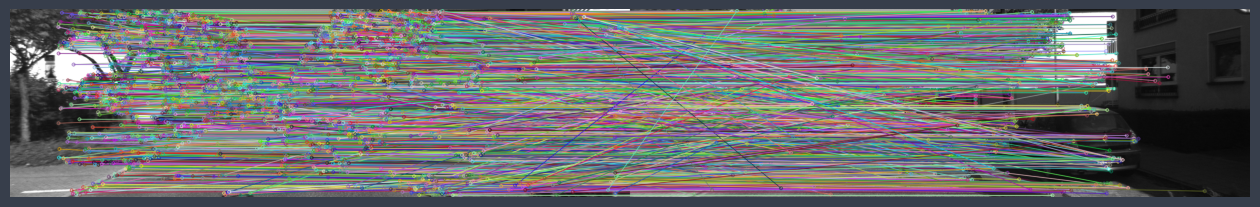

In [54]:
# Look at matched points using sgbm matcher
image_left = handler.first_image_left
image_right = handler.first_image_right
image_plus1 = handler.second_image_left # next image on the left camera
kp0, des0 = extract_features(image_left, 'sift', mask)
kp1, des1 = extract_features(image_plus1, 'sift', mask)
matches = match_features(des0, des1, matching='BF', detector='sift', sort=False)
print('Number of matches before filtering:', len(matches))
matches = [match[0] for match in matches] # get the first match from each list of matches
visualize_matches(image_left, kp0, image_plus1, kp1, matches)

`sort` can set to `False` because matches is already sort by itself.

In [55]:
matches = match_features(des0, des1, matching='BF', detector='sift', sort=False)
matches[0][0].distance # check the distance of the first match

292.147216796875

In [56]:
# Second closet match to this feature
matches[0][1].distance # check the distance of the first match

313.20440673828125

In [57]:
# 0.5 is dist_threshold for the filter_matches_distance function
# It mean we want those distance to be at least twice as far apart (ห่างกันอย่างน้อยสองเท่า) as the first match
matches[0][0].distance <= 0.5 * matches[0][1].distance

False

The distance between two match are pretty close together, which means that not powerful feature. so we want to filter this. 

#### **Filtering**

**SIFT**

Number of matches before filtering: 3206
Number of matches after filtering: 446
Time to match and filter:  0:00:00.313554


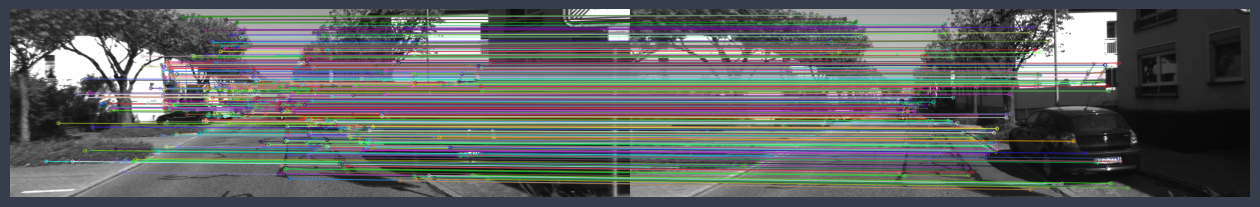

In [58]:
# Look at matched points using sgbm matcher
image_left = handler.first_image_left
image_right = handler.first_image_right
image_plus1 = handler.second_image_left
start = datetime.datetime.now() # start the timer to compute the disparity map
kp0, des0 = extract_features(image_left, 'sift')
kp1, des1 = extract_features(image_plus1, 'sift')
matches = match_features(des0, des1, matching='BF', detector='sift', sort=False)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.3)
print('Number of matches after filtering:', len(matches))
end = datetime.datetime.now() # end the timer to compute the disparity map
print('Time to match and filter: ', end-start)
visualize_matches(image_left, kp0, image_plus1, kp1, matches)

**ORB**

Number of matches before filtering: 500
Number of matches after filtering: 17
Time to match and filter:  0:00:01.084702


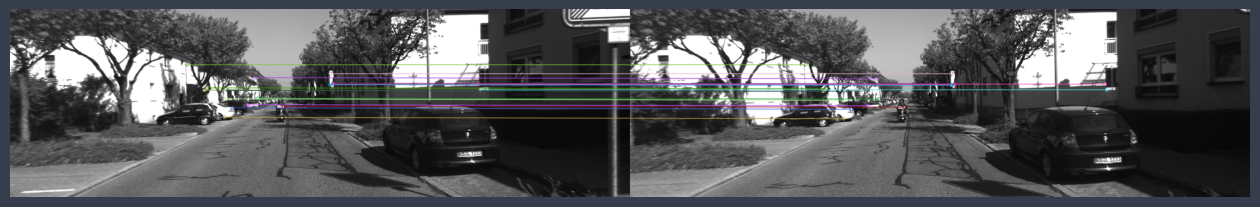

In [59]:
# Now to see the difference with ORB descriptor
image_left = handler.first_image_left
image_right = handler.first_image_right
image_plus1 = handler.second_image_left
start = datetime.datetime.now() # start the timer to compute the disparity map
kp0, des0 = extract_features(image_left, 'orb')
kp1, des1 = extract_features(image_plus1, 'orb')
matches = match_features(des0, des1, matching='BF', detector='orb', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.3)
print('Number of matches after filtering:', len(matches))
end = datetime.datetime.now() # end the timer to compute the disparity map
print('Time to match and filter: ', end-start)
visualize_matches(image_left, kp0, image_plus1, kp1, matches)

## **Estimate Motion with SolvePnPRansac**

In [60]:
kp1[0].pt # check the 2D pixel coordinates of the first keypoint in the second image

(797.0, 89.0)

In [61]:
def estimate_motion(match, kp1, kp2, k, depth1=None, max_depth=3000):
    """
    Estimate camera motion from a pair of subsequent image frames

    Arguments:
    match -- list of matched features from the pair of images
    kp1 -- list of the keypoints in the first image
    kp2 -- list of the keypoints in the second image
    k -- camera intrinsic calibration matrix 
    
    Optional arguments:
    depth1 -- Depth map of the first frame. Set to None to use Essential Matrix decomposition
    max_depth -- Threshold of depth to ignore matched features. 3000 is default

    Returns:
    rmat -- estimated 3x3 rotation matrix
    tvec -- estimated 3x1 translation vector
    image1_points -- matched feature pixel coordinates in the first image. 
                     image1_points[i] = [u, v] -> pixel coordinates of i-th match
    image2_points -- matched feature pixel coordinates in the second image. 
                     image2_points[i] = [u, v] -> pixel coordinates of i-th match
               
    """
    rmat = np.eye(3) # rotation matrix
    tvec = np.zeros((3, 1)) # translation vector
    # Get the matched points from the two images
    

    image1_points = np.float32([kp1[m.queryIdx].pt for m in match]) # list of 2D coordinates of features that match
    # We use match to figure out where the index is in the second image and then indexing our key point to make sure that we get corresponding 2D pixel location of this particular match
    image2_points = np.float32([kp2[m.trainIdx].pt for m in match])

    if depth1 is not None:
        # Get the intrinsic parameters of the camera
        cx = k[0, 2] # center x coordinate of the camera
        cy = k[1, 2] # center y coordinate of the camera
        fx = k[0, 0] # focal length in x direction
        fy = k[1, 1] # focal length in y direction
        object_points = np.zeros((0, 3))
        delete = []

        # Extract depth information of query image at match points and build 3D positions
        for i, (u, v) in enumerate(image1_points): # Going through each 2D pixel coordinates of our feature
            z = depth1[int(v), int(u)]
            # If the depth at the position of our matched feature is above 3000, then we
            # ignore this feature because we don't actually know the depth and it will throw
            # our calculations off. We add its index to a list of coordinates to delete from our
            # keypoint lists, and continue the loop. After the loop, we remove these indices
            if z > max_depth: # It means that the depth is not good estimate so not use it
                delete.append(i)
                continue
                
            # Use arithmetic to extract x and y (faster than using inverse of k)
            # Turn u,v (pixel) to x,y (meter)
            x = z*(u-cx)/fx
            y = z*(v-cy)/fy
            # u-cx = add cx to move origin back to center (pixel unit)
            # (u-cx)/fx = divide by fx (pixel) turn to unitless
            # z*(u-cx)/fx = multiply by z (depth) to get x in 3D space (in meters)
            
            # stack the 3D points x,y,z
            object_points = np.vstack([object_points, np.array([x, y, z])])
            # Equivalent math with dot product w/ inverse of k matrix, but SLOWER (see Appendix A)
            #object_points = np.vstack([object_points, np.linalg.inv(k).dot(z*np.array([u, v, 1]))])

        # Remove the points that depth is not good estimate
        # Delete after for loop because we were counting i sequentially
        image1_points = np.delete(image1_points, delete, 0)
        image2_points = np.delete(image2_points, delete, 0)
        
        # Use PnP algorithm with RANSAC for robustness to outliers
        _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)
        # rvec = rotation vector
        # tvec = translation vector, it explain where these points(object_points) are found on 2D image plane in second image(image2_points)
        #print('Number of inliers: {}/{} matched features'.format(len(inliers), len(match)))
        
        # Above function returns axis angle rotation representation rvec, use Rodrigues formula
        # to convert this to our desired format of a 3x3 rotation matrix
        rmat = cv2.Rodrigues(rvec)[0]
        # rmat = 3x3 rotation matrix
    
    else:
        # With no depth provided, use essential matrix decomposition instead. This is not really
        # very useful, since you will get a 3D motion tracking but the scale will be ambiguous
        image1_points_hom = np.hstack([image1_points, np.ones(len(image1_points)).reshape(-1,1)])
        image2_points_hom = np.hstack([image2_points, np.ones(len(image2_points)).reshape(-1,1)])
        E = cv2.findEssentialMat(image1_points, image2_points, k)[0]
        _, rmat, tvec, mask = cv2.recoverPose(E, image1_points, image2_points, k)
    
    return rmat, tvec, image1_points, image2_points

Now we have rotation matrix and a translation vector which explain the movement of the camera between the first frame that we look at and the second frame that we look at usinng the features that we detected using sift and described using sift matched using the distance between those descriptor vectors from the sift process and using z which is depth that calculated from our stero pair.

**Show estimate_motion**

In [62]:
k, rmat, tvec, _, _, _, _ = cv2.decomposeProjectionMatrix(handler.P0)
k

array([[718.856 ,   0.    , 607.1928],
       [  0.    , 718.856 , 185.2157],
       [  0.    ,   0.    ,   1.    ]])

In [63]:
kp0, des0 = extract_features(image_left, 'sift')
kp1, des1 = extract_features(image_plus1, 'sift')
matches = match_features(des0, des1, matching='BF', detector='sift', sort=False)
matches = filter_matches_distance(matches, 0.3)

depth = stereo_2_depth(handler.first_image_left, 
                       handler.first_image_right, 
                       handler.P0, 
                       handler.P1, 
                       matcher='sgbm', 
                       rgb=False, 
                       verbose=True, 
                       rectified=True)

Time to compute disparity map using StereoSGBM: 0:00:00.058300


In [64]:
rmat, tvec, image1_points, image2_points = estimate_motion(matches, kp0, kp1, k, depth)
print('Rotation matrix:\n', rmat.round(4)) # print the rotation matrix
print('Translation vector:\n', tvec.round(4)) # print the translation vector

Rotation matrix:
 [[ 1.      0.0025  0.0033]
 [-0.0025  1.      0.002 ]
 [-0.0033 -0.002   1.    ]]
Translation vector:
 [[-1.000e-04]
 [ 6.800e-03]
 [-6.679e-01]]


**Compare Transformation matrix between from estimate_motion and Ground Truth**

In [65]:
transformation_matrix = np.hstack((rmat, tvec)) # stack the rotation matrix and translation vector to make a 3x4 transformation matrix
print('Transformation matrix estimate_motion\n',transformation_matrix.round(4)) # print the transformation matrix

Transformation matrix estimate_motion
 [[ 1.000e+00  2.500e-03  3.300e-03 -1.000e-04]
 [-2.500e-03  1.000e+00  2.000e-03  6.800e-03]
 [-3.300e-03 -2.000e-03  1.000e+00 -6.679e-01]]


In [66]:
print('Transformation matrix Ground Truth\n',handler.gt[1].round(4)) # check the ground truth pose of the second image in the sequence

Transformation matrix Ground Truth
 [[ 1.000e+00  5.000e-04 -2.100e-03 -4.690e-02]
 [-5.000e-04  1.000e+00 -1.200e-03 -2.840e-02]
 [ 2.100e-03  1.200e-03  1.000e+00  8.587e-01]]


So TF from estimate_motion and Ground Truth are not same because the ground truth is being track in the first position of camera coordinate frame and then the second ground truth will be the origin of the camera where that is in relation to the first coordinate frame. And what we solve in estimate_motion is coordinate the origin of camera in first position is in the new coordinate frame.

So actually we solve this backwards but we can inverse TF to go in the other direction by making in to homogenous TF.

In [67]:
hom_trans_mat = np.eye(4) # create a 4x4 identity matrix
hom_trans_mat

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [76]:
hom_trans_mat[:3, :3] = rmat # set the top left 3x3 part of the matrix to the rotation matrix
hom_trans_mat[:3, 3] = tvec.T # set the top right 3x1 part of the matrix to the translation vector
print(hom_trans_mat.round(4))

[[ 1.000e+00  2.500e-03  3.300e-03 -1.000e-04]
 [-2.500e-03  1.000e+00  2.000e-03  6.800e-03]
 [-3.300e-03 -2.000e-03  1.000e+00 -6.679e-01]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]


In [77]:
print(np.linalg.inv(hom_trans_mat).round(4))

[[ 1.     -0.0025 -0.0033 -0.0022]
 [ 0.0025  1.     -0.002  -0.0081]
 [ 0.0033  0.002   1.      0.6679]
 [ 0.      0.      0.      1.    ]]


In [78]:

print(handler.gt[1].round(4)) # check the ground truth pose of the first image in the sequence

[[ 1.000e+00  5.000e-04 -2.100e-03 -4.690e-02]
 [-5.000e-04  1.000e+00 -1.200e-03 -2.840e-02]
 [ 2.100e-03  1.200e-03  1.000e+00  8.587e-01]]


## **Deploying the Pipeline**

This section will make a function that wrap up iterating through each frame of our data set and then combine all frame estimate of pose change in order to create a contiguous trajectory for the camera over time 

In [82]:
def visual_odometry(handler, detector='sift', matching='BF', filter_match_distance=None, 
                    stereo_matcher='sgbm', mask=None, depth_type='stereo', subset=None,
                    plot=False):
    '''
    Function to perform visual odometry on a sequence from the KITTI visual odometry dataset.
    Takes as input a Data_Handler object and optional parameters.
    
    Arguments:
    handler -- Data_Handler object instance
    
    Optional Arguments:
    detector -- (str) can be 'sift' or 'orb'. Default is 'sift'.
    matching -- (str) can be 'BF' for Brute Force or 'FLANN'. Default is 'BF'.
    filter_match_distance -- (float) value for ratio test on matched features. Default is None.
    stereo_matcher -- (str) can be 'bm' (faster) or 'sgbm' (more accurate). Default is 'bm'.
    mask -- (array) mask to reduce feature search area to where depth information available.
    depth_type -- (str) can be 'stereo' or set to None to use Essential matrix decomposition.
                        Note that scale will be incorrect with no depth used.
    subset -- (int) number of frames to compute. Defaults to None to compute all frames.
    plot -- (bool) whether to plot the estimated vs ground truth trajectory. Only works if
                   matplotlib is set to tk mode. Default is False.
    
    Returns:
    trajectory -- Array of shape Nx3x4 of estimated poses of vehicle for each computed frame.
    
    '''
    # Determine if handler has lidar data
    lidar = handler.lidar
    
    # Report methods being used to user
    print('Generating disparities with Stereo{}'.format(str.upper(stereo_matcher)))
    print('Detecting features with {} and matching with {}'.format(str.upper(detector), 
                                                                   matching))
    if filter_match_distance is not None:
        print('Filtering feature matches at threshold of {}*distance'.format(filter_match_distance))
    if lidar:
        print('Improving stereo depth estimation with lidar data')
    if subset is not None:
        #subset = subset + 1
        num_frames = subset
    else:
        # Set num_frames to one less than the number of frames so we have sequential images
        # in the last frame run.
        num_frames = handler.num_frames
        
    if plot:
        fig = plt.figure(figsize=(14, 14))
        ax = fig.add_subplot(projection='3d')
        ax.view_init(elev=-20, azim=270)
        xs = handler.gt[:, 0, 3]
        ys = handler.gt[:, 1, 3]
        zs = handler.gt[:, 2, 3]
        ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
        ax.plot(xs, ys, zs, c='k')
        
    # Establish homogeneous transformation matrix. First pose is identity    
    T_tot = np.eye(4) # First form before car move is identity matrix
    trajectory = np.zeros((num_frames, 3, 4))
    trajectory[0] = T_tot[:3, :] #first trajectory
    imheight = handler.imheight
    imwidth = handler.imwidth
    
    # Decompose left camera projection matrix to get intrinsic k matrix
    k_left, r_left, t_left = decompose_projection_matrix(handler.P0)
    
    if handler.low_memory:
        handler.reset_frames()
        image_plus1 = next(handler.images_left)
    
    # Iterate through all frames of the sequence
    for i in range(num_frames - 1):
        # Stop if we've reached the second to last frame, since we need two sequential frames
        #if i == num_frames - 1:
        #    break
        # Start timer for frame
        start = datetime.datetime.now()
        # Get our stereo images for depth estimation
        if handler.low_memory:
            image_left = image_plus1
            image_right = next(handler.images_right)
            # Get next frame in the left camera for visual odometry
            image_plus1 = next(handler.images_left)
        else:
            image_left = handler.images_left[i]
            image_right = handler.images_right[i]
            # Get next frame in the left camera for visual odometry
            image_plus1 = handler.images_left[i+1]
        
        # Estimate depth if using stereo depth estimation (recommended)
        if depth_type == 'stereo':
            depth = stereo_2_depth(image_left, 
                                   image_right, 
                                   P0=handler.P0, 
                                   P1=handler.P1,
                                   matcher=stereo_matcher)
        # Otherwise use Essential Matrix decomposition (ambiguous scale)
        else:
            depth = None
            
        # Supercede stereo depth estimations where lidar points are available
        if lidar:
            if handler.low_memory:
                pointcloud = next(handler.pointclouds)
            else:
                pointcloud = handler.pointclouds[i]
            lidar_depth = pointcloud2image(pointcloud, 
                                           imheight=imheight, 
                                           imwidth=imwidth, 
                                           Tr=handler.Tr, 
                                           P0=handler.P0)
            # indices = np.where(lidar_depth < 3000)
            indices = np.where(lidar_depth > 0)
            depth[indices] = lidar_depth[indices]
            
        # Get keypoints and descriptors for left camera image of two sequential frames
        kp0, des0 = extract_features(image_left, detector, mask)
        kp1, des1 = extract_features(image_plus1, detector, mask)
        
        # Get matches between features detected in the two images
        matches_unfilt = match_features(des0, 
                                        des1, 
                                        matching=matching, 
                                        detector=detector, 
                                        sort=True)
        
        
        # Filter matches if a distance threshold is provided by user
        if filter_match_distance is not None:
            matches = filter_matches_distance(matches_unfilt, filter_match_distance)
        else:
            matches = matches_unfilt

        # Estimate motion between sequential images of the left camera
        rmat, tvec, img1_points, img2_points = estimate_motion(matches, kp0, kp1, k_left, depth)
        
        # The following code is commented out because it is only necessary if you intend to
        # use very low distance ratios for match filtering. Feel free to uncomment and try
        # out using very low distance ratios, but if you do, comment out the above line.
        # Try to get motion with filter distance, if not increase threshold until success
        #try:
        #    rmat, tvec, img1_points, img2_points = estimate_motion(matches, 
        #                                                           kp0, 
        #                                                           kp1, 
        #                                                           k_left, 
        #                                                           depth)
        #except:
        #    filt_inc = 0.1
        #    while True:
        #        print('Not enough features after filter with threshold {},'.format(filter_match_distance),
        #              'raising threshold to {} until next frame.'.format(filter_match_distance + filt_inc)) 
        #        try:
        #            matches = filter_matches_distance(matches_unfilt, filter_match_distance+filt_inc)
        #            rmat, tvec, img1_points, img2_points = estimate_motion(matches, 
        #                                                                   kp0, 
        #                                                                   kp1, 
        #                                                                   k_left, 
        #                                                                   depth)
        #            break
        #        except:
        #            filt_inc += 0.1
        #            continue
                  
        # Create blank homogeneous transformation matrix
        Tmat = np.eye(4)
        # Place resulting rotation matrix  and translation vector in their proper locations
        # in homogeneous T matrix
        Tmat[:3, :3] = rmat
        Tmat[:3, 3] = tvec.T
        
        # The SolvePnPRansac() function computes a pose that relates points in the global
        # coordinate frame to the camera's pose. We used the camera's pose in the first image
        # as the global coordinate frame, reconstruct 3D positions of the features in the
        # image using stereo depth estimation, then find a pose which relates the camera in
        # the next frame to those 3D points. When tracking the vehicle pose over time, what we
        # actually want is to relate the points in the camera's coordinate frame to the global
        # frame, so we want the opposite (inverse) of the transformation matrix provided to us
        # by the SolvePnPRansac function. Recall from the earlier discussion that we can find
        # the inverse of a transformation matrix by making it homogeneous by adding a row of
        # (0, 0, 0, 1) to it, then taking its inverse. Further, we are tracking the vehicle
        # motion from the very first camera pose, so we need the cumulative product of the
        # inverses of each estimated camera pose given to us by SolvePnPRansac. Thus, below
        # we iteratively multiply the T_tot homogeneous transformation matrix that we 
        # instantiated before the for loop by the inverse of each successive pose we estimate,
        # and save its current values into our estimated poses at an index corresponding to our
        # current frame. This way, the transformation matrix at each index will be one that
        # relates 3D homogeneous coordinates in the camera's frame to the global coordinate
        # frame, which is the coordinate frame of the camera's first position. The translation
        # vector component of this transformation matrix will describe where the camera's curent
        # origin is in this global referece frame.
        T_tot = T_tot.dot(np.linalg.inv(Tmat))  # dotis combine two tf matrix.
                                                # Tmat inverse is the 3d coordinate of the origin of the camera 
                                                # in its second position in the global coordinate frame
                                                # which is the coordinate frame of the camera in its first position.
            
        # Place pose estimate in i+1 to correspond to the second image, which we estimated for
        trajectory[i+1, :, :] = T_tot[:3, :]    # Save Total tf up until this point in trajectory array
        # End the timer for the frame and report frame rate to user
        end = datetime.datetime.now()
        print('Time to compute frame {}:'.format(i+1), end-start)
        
        if plot:
            xs = trajectory[:i+2, 0, 3]
            ys = trajectory[:i+2, 1, 3]
            zs = trajectory[:i+2, 2, 3]
            plt.plot(xs, ys, zs, c='chartreuse')
            plt.pause(1e-32)
            
    if plot:        
        plt.close()
        
    return trajectory

In [83]:
# enable interactive plotting in a separate window
%matplotlib tk 

In [ ]:
trajectory_test = visual_odometry(handler,
                                  detector='sift', 
                                  matching='BF', 
                                  filter_match_distance=0.3, 
                                  stereo_matcher='sgbm', 
                                  mask=mask, 
                                  depth_type='stereo', 
                                  subset=None, # Number of limit frames
                                  plot=True)

Generating disparities with StereoSGBM
Detecting features with SIFT and matching with BF
Filtering feature matches at threshold of 0.3*distance
Time to compute frame 1: 0:00:00.450451
Time to compute frame 2: 0:00:00.341326
Time to compute frame 3: 0:00:00.323165
Time to compute frame 4: 0:00:00.319019
Time to compute frame 5: 0:00:00.315933
Time to compute frame 6: 0:00:00.316410
Time to compute frame 7: 0:00:00.323579
Time to compute frame 8: 0:00:00.317200
Time to compute frame 9: 0:00:00.316748
Time to compute frame 10: 0:00:00.329121
Time to compute frame 11: 0:00:00.305210
Time to compute frame 12: 0:00:00.280027
Time to compute frame 13: 0:00:00.275284
Time to compute frame 14: 0:00:00.270435
Time to compute frame 15: 0:00:00.270526
Time to compute frame 16: 0:00:00.270025
Time to compute frame 17: 0:00:00.265724
Time to compute frame 18: 0:00:00.275235
Time to compute frame 19: 0:00:00.282516
Time to compute frame 20: 0:00:00.287529
Time to compute frame 21: 0:00:00.297919
Time